In [1]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

In [2]:
data = load_dataset("emotion")

hf_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(hf_model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [3]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


In [4]:
data_encoded = data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model = (AutoModelForSequenceClassification.from_pretrained(hf_model, num_labels=6).to(device))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [8]:
!pip install -q huggingface_hub

In [9]:
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `text_clf` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.

In [10]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [11]:
batch_size = 64
training_args = TrainingArguments(
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    # evaluation_strategy = "epoch",
    disable_tqdm = True,
    push_to_hub = True,
    output_dir = "outputs"
)

def compute_metrics(predicts):
    labels = predicts.label_ids
    predicts = predicts.predictions.argmax(-1)
    f1 = f1_score(labels, predicts, average="weighted")
    acc = accuracy_score(labels, predicts)
    return {"accuracy": acc, "f1": f1}



trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=data_encoded["train"],
    eval_dataset=data_encoded["validation"],
    tokenizer=tokenizer
    )



trainer.train()

metrics = trainer.evaluate()

print(metrics)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3308775890.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.5248, 'grad_norm': 6.190255165100098, 'learning_rate': 4e-08, 'epoch': 2.0}
{'train_runtime': 235.5735, 'train_samples_per_second': 135.839, 'train_steps_per_second': 2.122, 'train_loss': 0.5247919921875, 'epoch': 2.0}
{'eval_loss': 0.21486760675907135, 'eval_accuracy': 0.9205, 'eval_f1': 0.9202331562448673, 'eval_runtime': 3.8727, 'eval_samples_per_second': 516.432, 'eval_steps_per_second': 8.263, 'epoch': 2.0}
{'eval_loss': 0.21486760675907135, 'eval_accuracy': 0.9205, 'eval_f1': 0.9202331562448673, 'eval_runtime': 3.8727, 'eval_samples_per_second': 516.432, 'eval_steps_per_second': 8.263, 'epoch': 2.0}


In [12]:
trainer.save_model("outputs/final_model")


events.out.tfevents.1754309549.5ea2050ed648.2581.1:   0%|          | 0.00/457 [00:00<?, ?B/s]

In [13]:
metrics

{'eval_loss': 0.21486760675907135,
 'eval_accuracy': 0.9205,
 'eval_f1': 0.9202331562448673,
 'eval_runtime': 3.8727,
 'eval_samples_per_second': 516.432,
 'eval_steps_per_second': 8.263,
 'epoch': 2.0}

{'eval_loss': 0.21486760675907135, 'eval_accuracy': 0.9205, 'eval_f1': 0.9202331562448673, 'eval_runtime': 4.0406, 'eval_samples_per_second': 494.978, 'eval_steps_per_second': 7.92, 'epoch': 2.0}


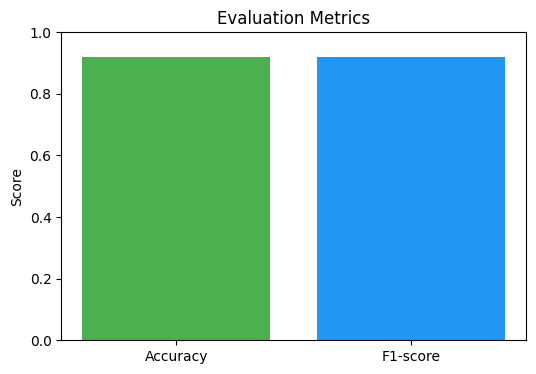

In [16]:
import matplotlib.pyplot as plt


metrics = trainer.evaluate()
accuracy = metrics["eval_accuracy"]
f1 = metrics["eval_f1"]


plt.figure(figsize=(6,4))
plt.bar(["Accuracy", "F1-score"], [accuracy, f1], color=["#4CAF50", "#2196F3"])
plt.ylim(0, 1)
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.show()